In [15]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-06-01T10:06:59.192129-05:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [16]:
import pandas as pd

La magia de matplotlib matplotlib notebook, es muy util para hacer plots mas visibles, pero es un poco complicada de usar ya que requiere el cerrar cada plot para poder continuar.

Alternativamente, se puede usar la magia %matplotlib inline, que es más sencilla ya que simplemente muestra el gráfico original en el jupyter notebook. Para modificar el tamaño de los plots en este caso basta con cambiar el parámetro general de matplotlib figure.figsize al tamaño de gráfico deseado (en pulgadas)


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,12) # 10 pulgadas de ancho y 10 de alto para todos los plots

En este apartado vamos a revisar el dataset. El objetivo sera tener un dataset lo mas parecido al original pero sin fallos en el mismo que puedan llevarnos a sacar conclusiones erroneas.

El input de este paso es el output del anterior

In [18]:
vehiculos = pd.read_csv("vehiculos.1.procesado_inicial.csv")

In [19]:
vehiculos.shape

(38436, 11)

### Duplicados

En este apartado se intentan ver dos cosas:

* Asegurarse de que datos que no debieran estar duplicados no lo están (por ejemplo, numeros de telefono)

* Revisar  si hay columnas que tengan un alto numero de duplicados, ya que pueden no aportar mucha informacion

Recordemos que las entidades posibles eran:   
    
    fabricante
    fabricante-modelo
    fabricante-modelo-año
    fabricante-año

De estas entidades, las unicas que no se deberian repetir coches especificos, es decir, fabricante+modelo +año

In [20]:
vehiculos['modelo_unico'] = vehiculos.fabricante.str.cat([vehiculos.modelo, vehiculos.year.apply(str)],sep='-')

In [21]:
vehiculos.modelo_unico.value_counts()

Jeep-Cherokee/Wagoneer-1985               24
Ford-F150 Pickup 2WD-1984                 19
GMC-C15 Pickup 2WD-1984                   19
Chevrolet-C10 Pickup 2WD-1984             19
GMC-C15 Pickup 2WD-1985                   18
                                          ..
Mercedes-Benz-C300-2015                    1
Mercedes-Benz-C300-2009                    1
Mercedes-Benz-C280 4matic-2007             1
Mercedes-Benz-C280 4matic-2006             1
smart-fortwo electric drive coupe-2016     1
Name: modelo_unico, Length: 17448, dtype: int64

Nos damos cuenta de que hay muchos repetidos, veamos un ejemplo

In [22]:
vehiculos[vehiculos.modelo_unico=='Chevrolet-C1500 Pickup 2WD-1991'].head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,modelo_unico
4957,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4958,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4959,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4960,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4961,Chevrolet,C1500 Pickup 2WD,1991,5.0,8.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,15,592.466667,Chevrolet-C1500 Pickup 2WD-1991


Como vemos , cada modelo unico tiene diferentes configuraciones de cada coche (3 velocidades o 4 por ejemplo)

Por lo tanto, solo vamos a considerar duplicados aquellos records que sean idénticos en todas sus columnas

In [23]:
vehiculos[vehiculos.duplicated()].shape

(1506, 12)

Vemos que hay 1506 records duplicados, podemos eliminarlos para el resto del análisis ya que pueden distorsionar las conclusiones

In [24]:
vehiculos.shape

(38436, 12)

In [25]:
vehiculos = vehiculos.drop_duplicates()
vehiculos.shape

(36930, 12)

Borramos la columna `modelo_unico`

In [26]:
del vehiculos['modelo_unico']

Ahora falta ver si hay variables en las que haya una gran cantidad de records que tengan el mismo valor (cardinalidad).

In [28]:
n_records = len(vehiculos)
n_records

36930

In [31]:
n_records = len(vehiculos)
def valores_duplicados_col(df):
    for columna in df:
        n_por_valor = df[columna].value_counts()
        mas_comun = n_por_valor.iloc[0]
        menos_comun = n_por_valor.iloc[-1]
        print("{} | {}-{} | {}".format(
            df[columna].name,
            round(mas_comun / (1.0*n_records),3),
            round(menos_comun / (1.0*n_records),3),
            df[columna].dtype
        ))

valores_duplicados_col(vehiculos)

fabricante | 0.1-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.353-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


Vemos que los campos `traccion, transmission, cilindros y combustible` pueden tener un problema de valores repetidos, en realidad 30% no es algo muy dramatico, seria distinto si el valor mas comun tuviera un 90%.

In [38]:
vehiculos.traccion.value_counts(normalize=True)

Front-Wheel Drive             0.360280
Rear-Wheel Drive              0.352863
4-Wheel or All-Wheel Drive    0.177345
All-Wheel Drive               0.062325
4-Wheel Drive                 0.030886
2-Wheel Drive                 0.011402
Part-time 4-Wheel Drive       0.004899
Name: traccion, dtype: float64

Vemos que esto tiene sentido, ya que la inmensa mayoria de vehiculos tienen traccion a dos ruedas, sean delanteras o traseras. 

En este caso alguien con conocimiento de dominio podria darse cuenta de que probablemente 2-Wheel Drive sea simplemente una clasificacion distinta de Front o Rear. 

https://www.edmunds.com/car-technology/what-wheel-drive.html

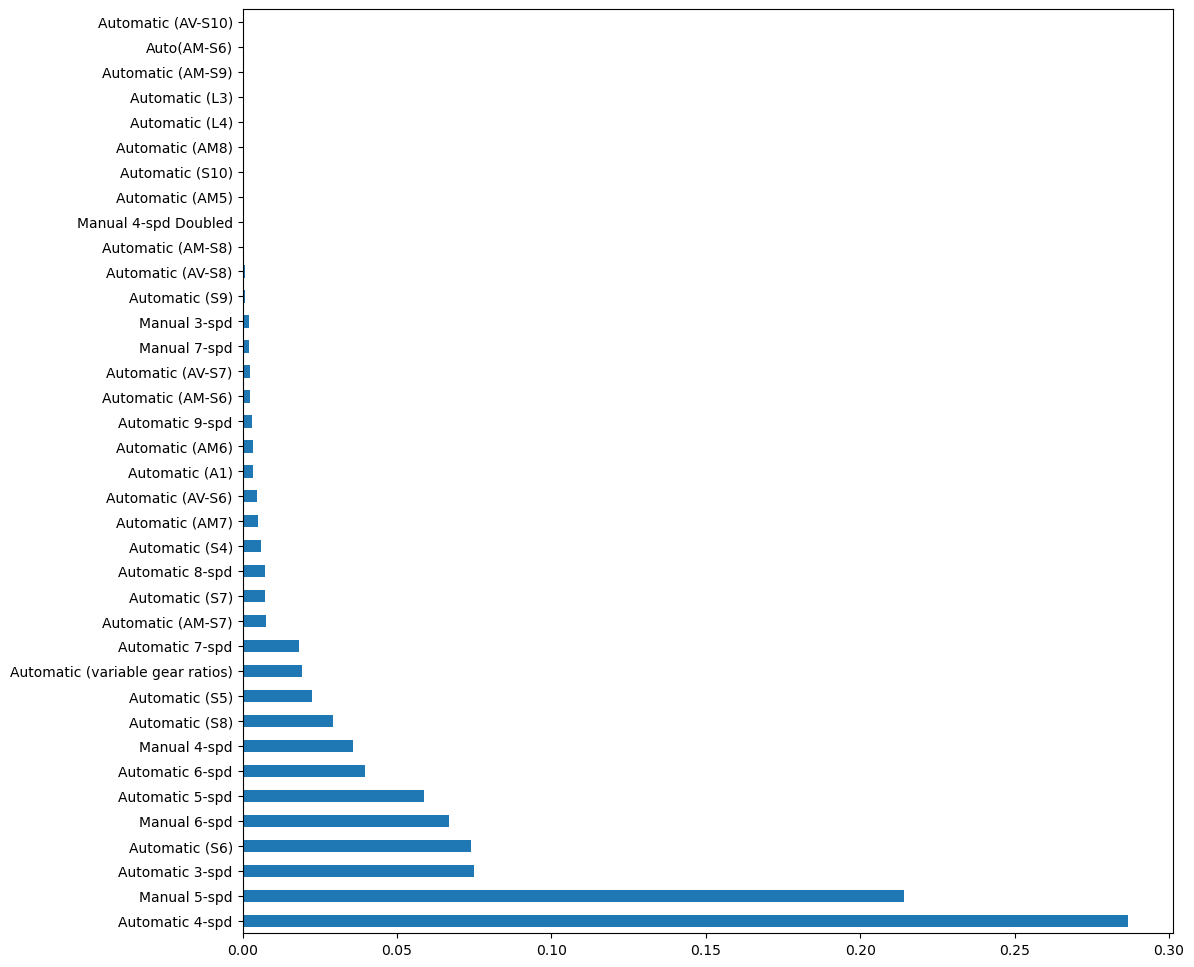

In [39]:
vehiculos.transmision.value_counts(normalize=True).plot.barh();

Vemos que aunque transmisión tenga una cardinalidad relativamente alta, en realidad muestra una distribución de tipos, con dos clases mayoritarias

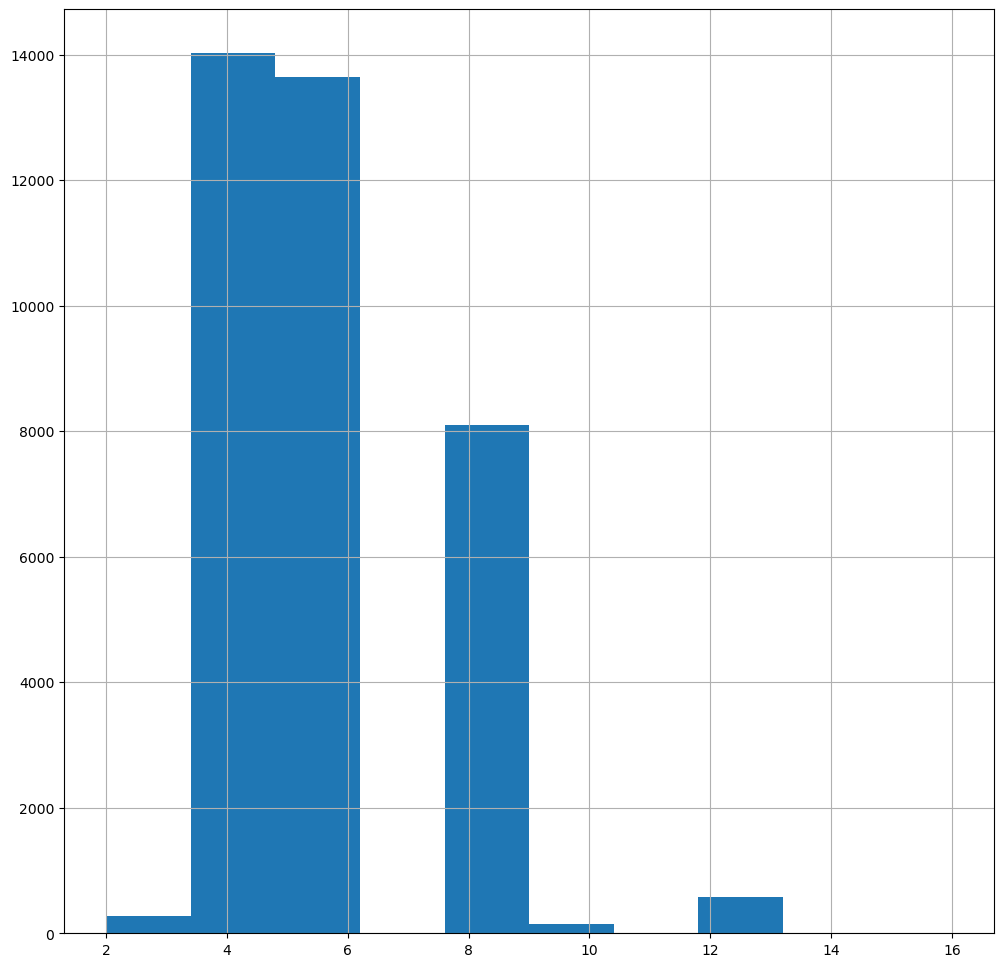

In [40]:
vehiculos.cilindros.hist();

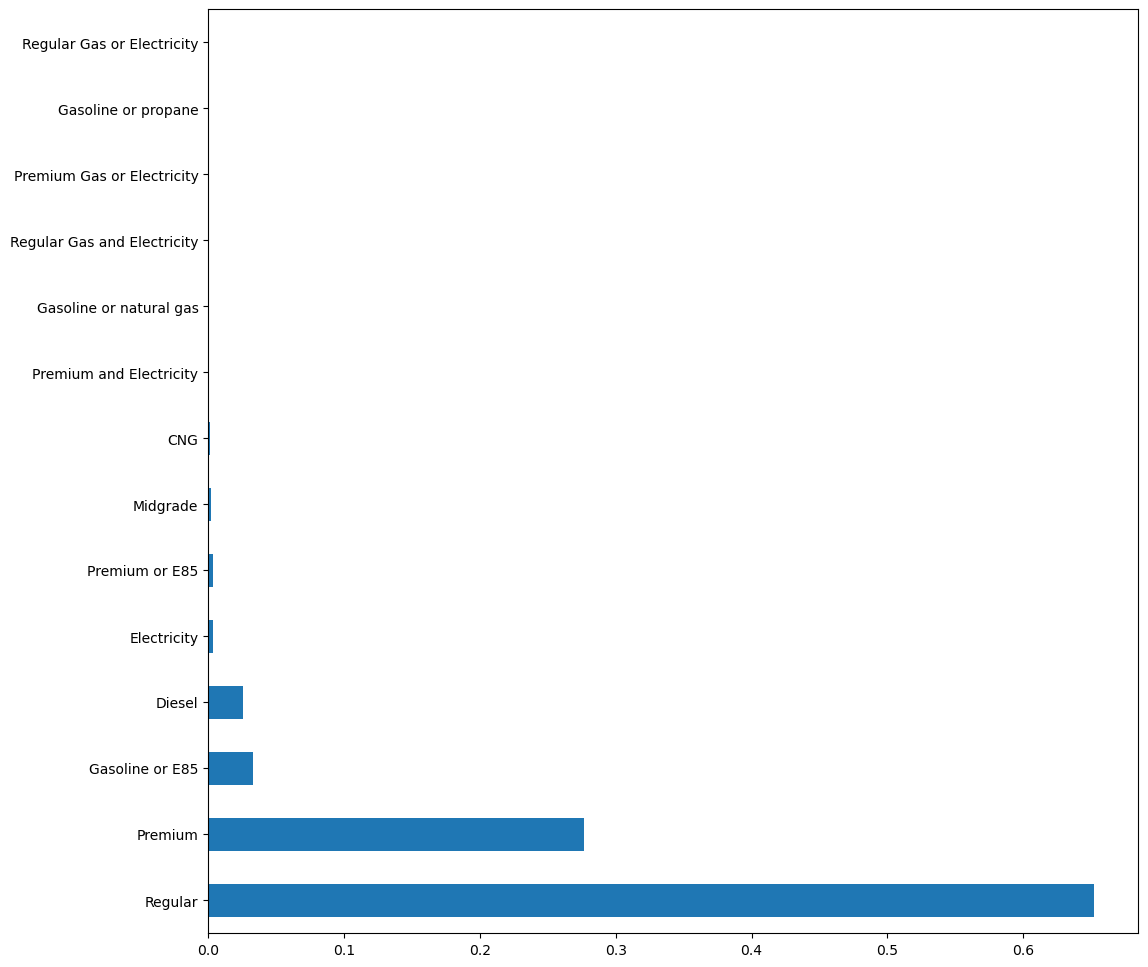

In [41]:
vehiculos.combustible.value_counts(normalize=True).plot.barh();

Vemos que la columna `combustible` si puede tener un problema al tener el 65% de los casos gasolina `Regular`

### Valores inexistentes
son valores que son nulos pero que no son validos

In [42]:
n_records = len(vehiculos)
def valores_inexistentes_col(df):
    for columna in df:
        print("{} | {} | {}".format(
            df[columna].name, len(df[df[columna].isnull()]) / (1.0*n_records), df[columna].dtype
        ))

valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


Vemos que campo `traccion, cilindros y transmision` tienen valores inexistentes. Sin embargo son cantidades despreciables (maximo es la variable traccion con un 3% inexistente)


### Valores extremos (outliers)

Para detectar valores extremos una medida general es considerar outliers aquellos valores con una puntuación Z (z score) mayor de 3, esto es, que se alejan 3 veces o mas desviaciones standard de la media.

El z score se define como:

$$z(x)= \frac{x-\mu}{\sigma}$$

In [43]:
from scipy import stats
import numpy as np

def outliers_col(df):
    for columna in df:
        if df[columna].dtype != np.object:
            n_outliers = len(df[np.abs(stats.zscore(df[columna])) > 3])    
            print("{} | {} | {}".format(
                df[columna].name,
                n_outliers,
                df[columna].dtype
        ))

outliers_col(vehiculos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 233 | int64
co2 | 358 | float64


C:\Users\jefer\AppData\Local\Temp\ipykernel_6196\510012546.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if df[columna].dtype != np.object:


Vemos que las variables de consumo y co2 tienen outliers. Podemos hacer un boxplot para visualizar esto mejor

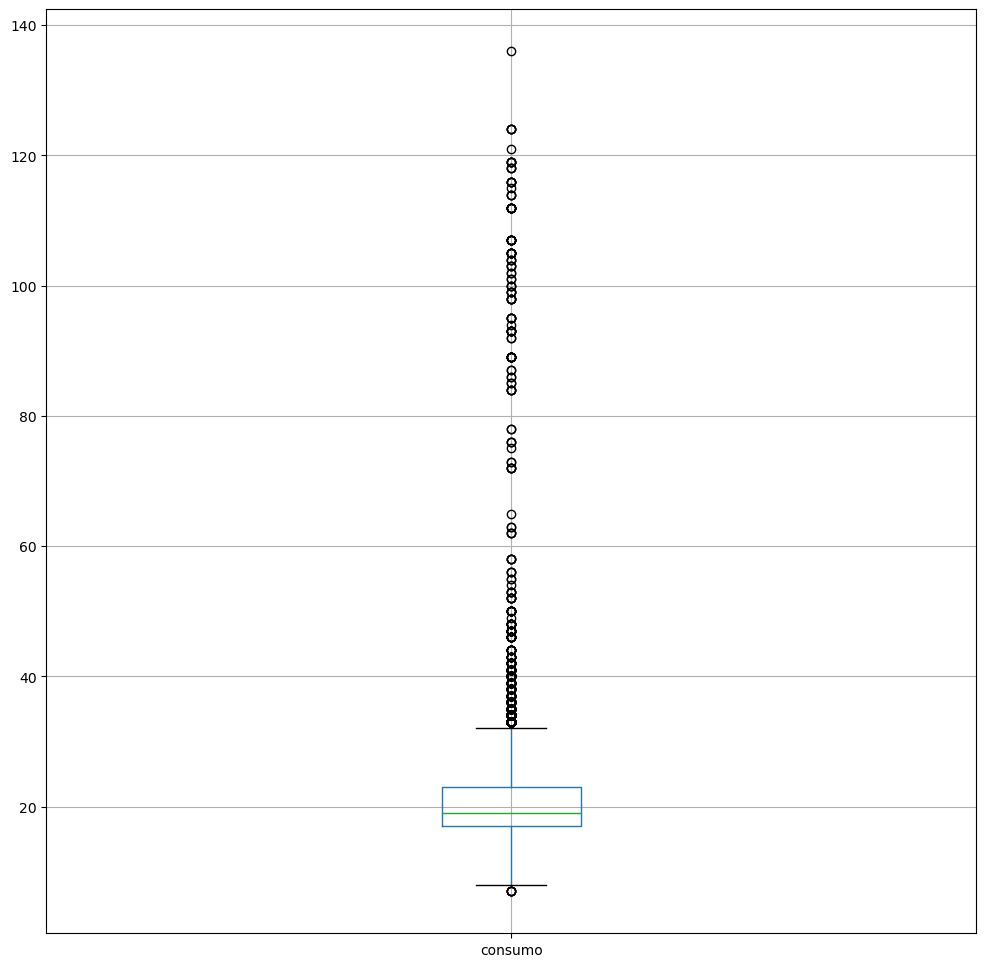

In [44]:
vehiculos.boxplot(column='consumo');

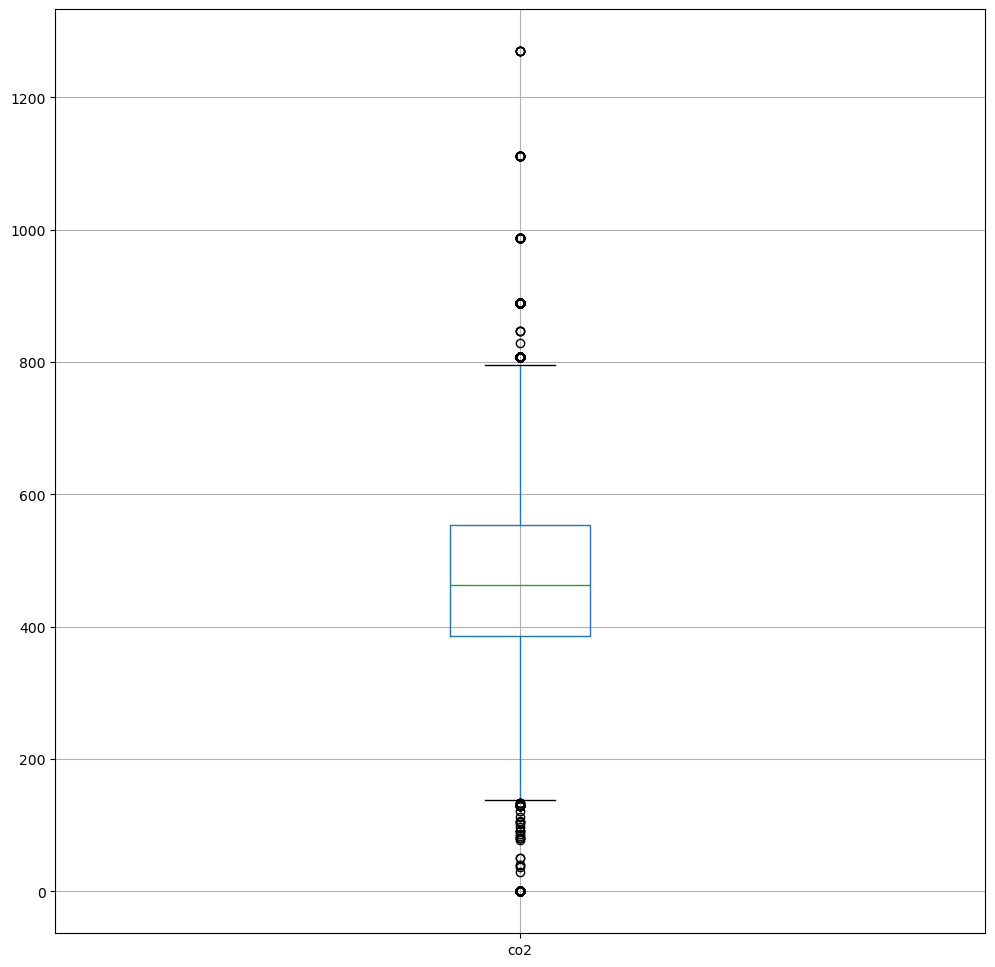

In [45]:
vehiculos.boxplot(column='co2');

Vemos que en cuanto a consumo hay algunos coches que contaminan mas de lo normal y otros que contaminan menos de lo normal, tambien vemos que hay coches que no contaminan nada!

Es posible que haya coches que no usen gasolina en el dataset?

In [46]:
vehiculos[vehiculos.co2==0].combustible.unique()

array(['Electricity'], dtype=object)

In [48]:
vehiculos.combustible.unique()

array(['Regular', 'Premium', 'Diesel', 'Premium and Electricity',
       'Premium or E85', 'Electricity', 'Premium Gas or Electricity',
       'Gasoline or E85', 'Gasoline or natural gas', 'CNG',
       'Regular Gas or Electricity', 'Midgrade',
       'Regular Gas and Electricity', 'Gasoline or propane'], dtype=object)

Vemos que en este dataset hay vehiculos hibridos y vehiculos electricos puros. Dado que el objetivo es la contaminacion, convendria remover al menos aquellos vehiculos que no contaminan!

In [49]:
vehiculos_no_electricos = vehiculos[vehiculos.co2>0]

In [56]:
vehiculos_no_electricos[vehiculos.co2>0].combustible.unique()

C:\Users\jefer\AppData\Local\Temp\ipykernel_6196\778299719.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vehiculos_no_electricos[vehiculos.co2>0].combustible.unique()


array(['Regular', 'Premium', 'Diesel', 'Premium and Electricity',
       'Premium or E85', 'Premium Gas or Electricity', 'Gasoline or E85',
       'Gasoline or natural gas', 'CNG', 'Regular Gas or Electricity',
       'Midgrade', 'Regular Gas and Electricity', 'Gasoline or propane'],
      dtype=object)

Ya que hemos descubierto esto, volvamos a revisar los datos con el nuevo dataset

In [50]:
outliers_col(vehiculos_no_electricos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 400 | int64
co2 | 221 | float64


C:\Users\jefer\AppData\Local\Temp\ipykernel_6196\510012546.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if df[columna].dtype != np.object:


Vemos que siguen habiendo outliers en cuanto a consumo y co2. ¿Será por que los vehículos híbridos consumen menos? Si fuera por esto estos valores extremos son valores perfectamente válidos y por tanto no deberíamos eliminarlos

In [51]:
vehiculos_no_electricos[
    np.abs(stats.zscore(vehiculos_no_electricos["consumo"])) > 3
].combustible.value_counts(normalize=True)

Regular                        0.7175
Diesel                         0.1525
Premium                        0.0550
Regular Gas and Electricity    0.0475
Premium Gas or Electricity     0.0200
Regular Gas or Electricity     0.0050
Premium and Electricity        0.0025
Name: combustible, dtype: float64

Vemos que no es el caso, que hay outliers en un rango de combustibles tanto híbridos como no híbridos. Asi que son outliers reales.

In [52]:
valores_duplicados_col(vehiculos_no_electricos)

fabricante | 0.099-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.351-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


### Valores inexistentes

In [57]:
valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


Ahora vemos que no hay valores inexistentes extremos en ninguna variable. La variable con mayor numero de valores inexistentes es traccion (2%). Obviamente, los coches electricos no tienen motor de gasolina y por tanto, no tienen cilindros

### Conclusion
- Hay 1506 records duplicados (los hemos removido)
- las variables `desplazamiento, cilindros, transmision y traccion tienen valores inexistentes`
- La variable `combustible` tiene una clase dominante (65% de coches tienen combustible `Regular`)
- hay un outlier en las variables `co2` y `consumo`
- Hay coches hibridos y coches electricos (hemos removido estos ultimos ya que no contaminan).

### Exportamos

In [58]:
vehiculos_no_electricos.to_csv("vehiculos.2.limpio_analisis.csv", index=False)